In [ ]:
import numpy as np

generation_path = "./runout{i}/generated_batch_{j}_samples.npy"
original_path = "./runout{i}/original_batch_{j}_samples.npy"
out_path = "./Porosity(BUG).txt"

with open(out_path, "w", encoding="utf-8") as f:
    f.write("Index, Original Porosity, Generated Porosity\n")

for i in range(1,21):
    for j in range(82):
        generations = np.load(generation_path.format(i=i,j=j))  
        original = np.load(original_path.format(i=i,j=j))  

        for n in range(generations.shape[0]):
            idx = i*j * 4 + n
            generated_data = generations[n]
            original_data = original[n]
            porosity_original = np.mean(original_data)
            porosity_generated = np.mean(generated_data)
            print(f"Index: {idx}, Original Porosity: {porosity_original:.4f}, Generated Porosity: {porosity_generated:.4f}")

            with open(out_path, "a", encoding="utf-8") as f:
                f.write(f"{idx},{porosity_original:.6f},{porosity_generated:.6f}\n")


In [2]:
import pandas as pd
from scipy.stats import sem, t
import numpy as np

porosity_bug_path  = r"./Porosity(BUG).txt"
porosity_clay_path = r"./Porosity(Claystone).txt" 

def load_porosity_matrix_and_ci(txt_path, n_runs=20, n_per_run=328, conf=0.95):
    df = pd.read_csv(txt_path) 
    df.columns = df.columns.str.strip()
    porosity_original = df["Original Porosity"].to_numpy()
    porosity_generated = df["Generated Porosity"].to_numpy()
    need = n_runs * n_per_run
    porosity_2d_original = porosity_original[:need].reshape(n_runs, n_per_run)        # (20, N)
    mean_original = np.nanmean(porosity_2d_original, axis=0)
    
    porosity_2d_generated = porosity_generated[:need].reshape(n_runs, n_per_run)        # (20, N)
    mean_generated = np.nanmean(porosity_2d_generated, axis=0)
    half  = sem(porosity_2d_generated, axis=0, nan_policy='omit') * t.ppf((1 + conf) / 2., n_runs - 1)
    lower, upper = mean_generated - half, np.minimum(mean_generated + half, 1.0)

    return mean_original, mean_generated, lower, upper

mean_bug_original, mean_bug_generated, lower_bug, upper_bug = load_porosity_matrix_and_ci(porosity_bug_path)
mean_clay_original, mean_clay_generated, lower_clay, upper_clay = load_porosity_matrix_and_ci(porosity_clay_path)

max clay orig: 0.33287400000000006  max clay genm: 0.32625494999999993
min clay orig: 0.16205699999999995  min clay genm: 0.11660445
[0.19474402]
[0.19258708]
[0.2579472]
[0.2382335]


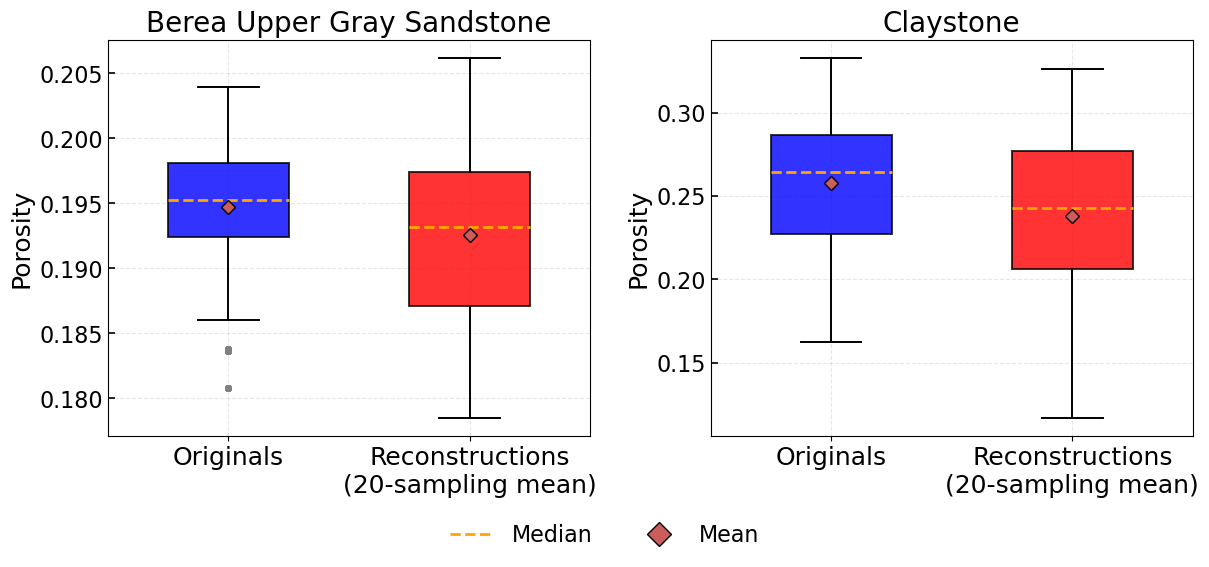

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

N_RUNS, N_PER_RUN = 20, 328 

def per_sample_original_and_genmean(txt_path, n_runs=N_RUNS, n_per_run=N_PER_RUN):
    df = pd.read_csv(txt_path)
    df.columns = df.columns.str.strip()

    orig = df["Original Porosity"].to_numpy()[:n_runs * n_per_run]
    gen  = df["Generated Porosity"].to_numpy()[:n_runs * n_per_run]

    orig_2d = orig.reshape(n_runs, n_per_run)   # (20, N)
    gen_2d  = gen.reshape(n_runs, n_per_run)    # (20, N)

    orig_per_sample = np.nanmean(orig_2d, axis=0)     # (N,)
    genm_per_sample = np.nanmean(gen_2d,  axis=0)     # (N,)
    return orig_per_sample, genm_per_sample

bug_orig,  bug_genm  = per_sample_original_and_genmean(porosity_bug_path)
clay_orig, clay_genm = per_sample_original_and_genmean(porosity_clay_path)

print("max clay orig:", np.max(clay_orig), " max clay genm:", np.max(clay_genm))
print("min clay orig:", np.min(clay_orig), " min clay genm:", np.min(clay_genm))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = {"Original": "#0000FF", "Generated-mean20": "#FF0000"}

def boxpanel(ax, orig, genm, title):
    data = [orig, genm]
    labels = ["Originals", "Reconstructions\n(20-sampling mean)"] 
    bp = ax.boxplot(
        data, patch_artist=True, whis=1.5, widths=0.5, showmeans=True,
        boxprops=dict(color='black', linewidth=1.4),
        medianprops=dict(color='orange', linestyle='--', linewidth=2),
        meanprops=dict(marker='D', markersize=7,markerfacecolor='indianred', markeredgecolor='black'),
        whiskerprops=dict(color='black', linewidth=1.4),
        capprops=dict(color='black', linewidth=1.4),
        flierprops=dict(marker='o', markersize=4,markerfacecolor='gray', markeredgecolor='gray')
    )
    print(bp['means'][0].get_ydata())
    print(bp['means'][1].get_ydata())
    
    for patch, c in zip(bp['boxes'], [colors["Original"], colors["Generated-mean20"]]):
        patch.set_facecolor(c); patch.set_alpha(0.8)

    ax.set_xticks([1, 2]); ax.set_xticklabels(labels, fontsize=18)
    ax.set_ylabel("Porosity", fontsize=18)
    ax.set_title(title, fontsize=20)
    ax.grid(True, ls="--", alpha=0.3)
    ax.tick_params(axis='y', labelsize=16, direction='in', length=5, width=1.2)

boxpanel(axes[0], bug_orig,  bug_genm,  "Berea Upper Gray Sandstone")
boxpanel(axes[1], clay_orig, clay_genm, "Claystone")

handles = [
    Line2D([0], [0], color='orange', linestyle='--', lw=2, label='Median'),
    Line2D([0], [0], marker='D', markersize=12, color='w',
           markerfacecolor='indianred', markeredgecolor='black', label='Mean'),
]
fig.legend(handles=handles, loc='lower center', ncol=2, frameon=False, fontsize=16)
plt.subplots_adjust(bottom=0.22, wspace=0.25)
plt.savefig("./Porosity_Boxplot.png", dpi=900)
plt.show()